In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('seaborn')

from sklearn.preprocessing import StandardScaler, RobustScaler, normalize, MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import silhouette_score

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC

from sklearn.metrics import f1_score, make_scorer, classification_report

import random
np.random.seed(12345)

# Reclassifying positions of Fantasy Premier League players

![title](img/premier-league-header.jpg)

# Problem statement and context

The Fantasy Premier League is amongst the most popular fantasy sport games in the world. Last year alone, it was played by over 6 million players. Of course, I am one of those 6 million people who willingly spend a good few hours a week to scout players, assess teams and plot transfer strategies, only to make watching football games more engaging.

The idea of the game is simple - you construct a fantasy team by selecting 2 goalkeeprs, 5 defenders, 5 midfielders and 3 attackers from the 20 Premier League teams and try to fit the best picks within your budget. Every week you field your best 11 and the performance of the players in the actual games are transposed into points for your fantasy team. At the end of the season, if you manage to win your league in competition with your mates, you are proclaimed a Champion and it is undisputed that you have superior football knowledge and tactical thinking... all until the next season.

The challenge we are facing is that players are racking up points on different criteria, based on their position on the field. This can be reviewed in the Fantasy Premier League website but without going into too much detail, every player gets points for goals, assists and overall perfromance, while goalkeepers and defenders receive points for keeping "clean sheets".

Of course, this means that when we are choosing our defenders, we want to maximize their potential attacking returns. Last season Trent Alexander Arnold, a defender for Liverpool FC, won a Guiness World record for the defender with the most assists in a Premier League season. His team-mate Andrew Robertson wasn't far behind.

The problem we are posing here is that we want to identify, the positions of the players not by their designated positions in their teams but by their underlying statistics. 

We want to find those defenders who have statistics similar to those of midfielders and attackers; and midfielders who who have statistics similar to attackers. Those will be players that we think can maximize our Fantasy Premier League points potential.

On the other hand, we want to find midfielders who have statistics similar to those of defenders; and attackers who have statistics similar to those of midfielders. Such types of players are essential for the performance of any team but we think those have a more limited Fantasy Premier League points potential.

That is, while there is value in the latter, we value the former more.

# Data pre-processing

Thanks to Vaastav Ananad, who is maintaining a fantastic GitHub repo with Fantasy Premier league statistics from previous seasons, we can get the perfromance of each player against each team in the 2018/2019 season. We will load the datasets and get the information we need. To normalize the data we are going to keep  players who have played at least 90 minutes, drop the goalkeepers and calculate statistics per minute on the pitch.

We end up with a dataframe containing all defenders, midfielders and attackers who have played at least 90 minutes in the 2018/2019 season and all of their performance statistics (per minute).

In [3]:
# read dataset all gameweeks
data_players = pd.read_csv("merged_gw.csv", encoding='latin-1')

# transform data to totals and sort 
data_players = data_players.groupby(['element']).sum().reset_index()
data_players.sort_values(by = ['element', "GW"], inplace = True)

In [4]:
# read dataset player stats
data_totals = pd.read_csv("players_raw.csv", encoding='latin-1')

# convert player position to integer
data_totals.element_type = data_totals.element_type.astype(int)

# rename duplicate columns from second dataset
data_totals = data_totals.rename(columns={"minutes": "minutes_season", "goals_scored": "goals_scored_season",
                                         "assists": "assists_season"})

In [5]:
# merge two dataframes
data = data_players.merge(data_totals, how = 'outer', left_on='element', right_on = 'id')

# select only player statistics as features
data = data[['GW', 'element', 'element_type', 'minutes', 'assists', 'attempted_passes', 
             'big_chances_created', 'big_chances_missed', 'clearances_blocks_interceptions', 
             'completed_passes', 'dribbles', 'errors_leading_to_goal_attempt', 'fouls', 
             'goals_scored', 'key_passes', 'offside', 'open_play_crosses', 'recoveries', 
             'tackled', 'tackles', 'target_missed']]

# remove players who have played less than 90 minutes throughout the season
data = data[data.minutes > 90]

# drop goalkeepers from dataframe
data = data[data.element_type != 1]

data.shape

(418, 21)

In [6]:
# review merged df

def export_csv (df):
    export_csv = df.to_csv (r'C:\Users\IoanDjambov\Desktop\Data Science\SoftUni_Machine_Learning_Course\Fantasy_Soft_Uni\export_dataframe.csv',
                        index = None, header=True)

In [7]:
# new variable to store player type and ID
elements = data[["element", "element_type"]]

# get statistics per minute
data = data.div(data.minutes, axis = 0)

# restore player type and player ID back to normal
data[["element", "element_type"]] = elements[["element", "element_type"]]

data.head(10)

,GW,element,element_type,minutes,assists,attempted_passes,big_chances_created,big_chances_missed,clearances_blocks_interceptions,completed_passes,...,errors_leading_to_goal_attempt,fouls,goals_scored,key_passes,offside,open_play_crosses,recoveries,tackled,tackles,target_missed
2,0.560572,3,2,1.0,0.000000,0.669676,0.000000,0.000752,0.084274,0.616253,...,0.000000,0.006772,0.002257,0.001505,0.000000,0.000000,0.059443,0.002257,0.008277,0.000752
3,0.486292,4,2,1.0,0.003264,0.511097,0.002611,0.000000,0.035901,0.430157,...,0.001958,0.010444,0.000000,0.005222,0.000653,0.005875,0.051567,0.015666,0.007833,0.003916
4,0.400538,5,2,1.0,0.002151,0.628495,0.002151,0.000538,0.048387,0.549462,...,0.000000,0.009140,0.000538,0.005914,0.000538,0.002151,0.053226,0.005376,0.004301,0.001075
5,0.924318,6,2,1.0,0.000000,0.763027,0.000000,0.000000,0.069479,0.666253,...,0.000000,0.007444,0.000000,0.002481,0.000000,0.000000,0.068238,0.006203,0.007444,0.002481
6,0.285331,7,2,1.0,0.000000,0.677135,0.000000,0.000383,0.088472,0.553045,...,0.000000,0.016086,0.000766,0.002298,0.001532,0.000383,0.045193,0.004213,0.011490,0.003064
7,0.395016,8,2,1.0,0.003712,0.515376,0.004772,0.000000,0.027041,0.400318,...,0.001060,0.011135,0.000000,0.016437,0.005302,0.006363,0.066808,0.014846,0.008484,0.002121
8,0.286156,9,2,1.0,0.000000,0.573859,0.000387,0.000773,0.071539,0.451663,...,0.001160,0.013148,0.000773,0.006187,0.000000,0.000000,0.087394,0.013534,0.007734,0.005027
9,5.068027,10,2,1.0,0.000000,0.938776,0.006803,0.000000,0.081633,0.870748,...,0.000000,0.013605,0.000000,0.006803,0.000000,0.000000,0.034014,0.000000,0.000000,0.013605
10,0.796791,11,2,1.0,0.000000,0.512299,0.000000,0.000000,0.037433,0.403209,...,0.000000,0.011765,0.000000,0.003209,0.002139,0.001070,0.043850,0.016043,0.008556,0.001070
11,0.338944,12,2,1.0,0.000910,0.630573,0.000455,0.000000,0.069154,0.563694,...,0.000455,0.016833,0.000455,0.002275,0.000000,0.000455,0.046406,0.003185,0.007734,0.003185


In [8]:
data.set_index("element", inplace = True)

In [9]:
data.shape

(418, 20)

In [10]:
# check for empty values
data = data.apply (pd.to_numeric, errors='coerce')
data = data.dropna()

# drop GW and minutes from df
data = data.drop(["GW", "minutes"], axis = 1)

In [11]:
data.shape

(418, 18)

In [12]:
# easier to compare element_type vs cluster assignments (0 - defender, 1 - midfielder, 2 - attacker)
data["element_type"] = data["element_type"].apply(lambda x: x - 2)

In [13]:
log_data = np.log(data+1)

# Exploratory data analysis 

We now have the dataframe prepared and we can perform exploratory data analysis through visualizations. Intuituvely, we want to have a look at the distributions for all the features. It is expected that those distributions are skewed as in professional sports you have a performance standard and only a handful of athletes manage to significantly and constantly outperform that standard.

As we observe the distributions, we can see that 'attacking features' such as goals scored, assists, big chances created etc have a very strong positive skew, highlighting the point mentioned above. In terms of the more 'defensive features' such as recoveries and tackles, the distribution ressmebles more of a Gaussian distribution. However, in general, the isolated feature distributions are right-skewed which may be an issue for some clustering algorithms. 

A logaritmic transformation (x+1) is a suitable way of transforming skewed data that contains zero values (Wade, 2018). RobustScaler is another way to notmalize distributions and to reduce the  effect of outliers (Hale, 2019). Both approaches were applied and tested for the dataset but the log transformation didn't have much impact on the distributions, and the RobustScaler had a negative impact on the clustering. Due to those reasons we are scaling the data using StandardScaler as this wil transform the features, so those are closer to normally distributed (Hale, 2019).

As a working assumption, in the context of the problem, we assume that those distributions are normal. 

In [14]:
# plot distributions of all player stats per minute
def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(15, 15))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(var_name+" distribution")
    fig.tight_layout()  
    
    plt.show()

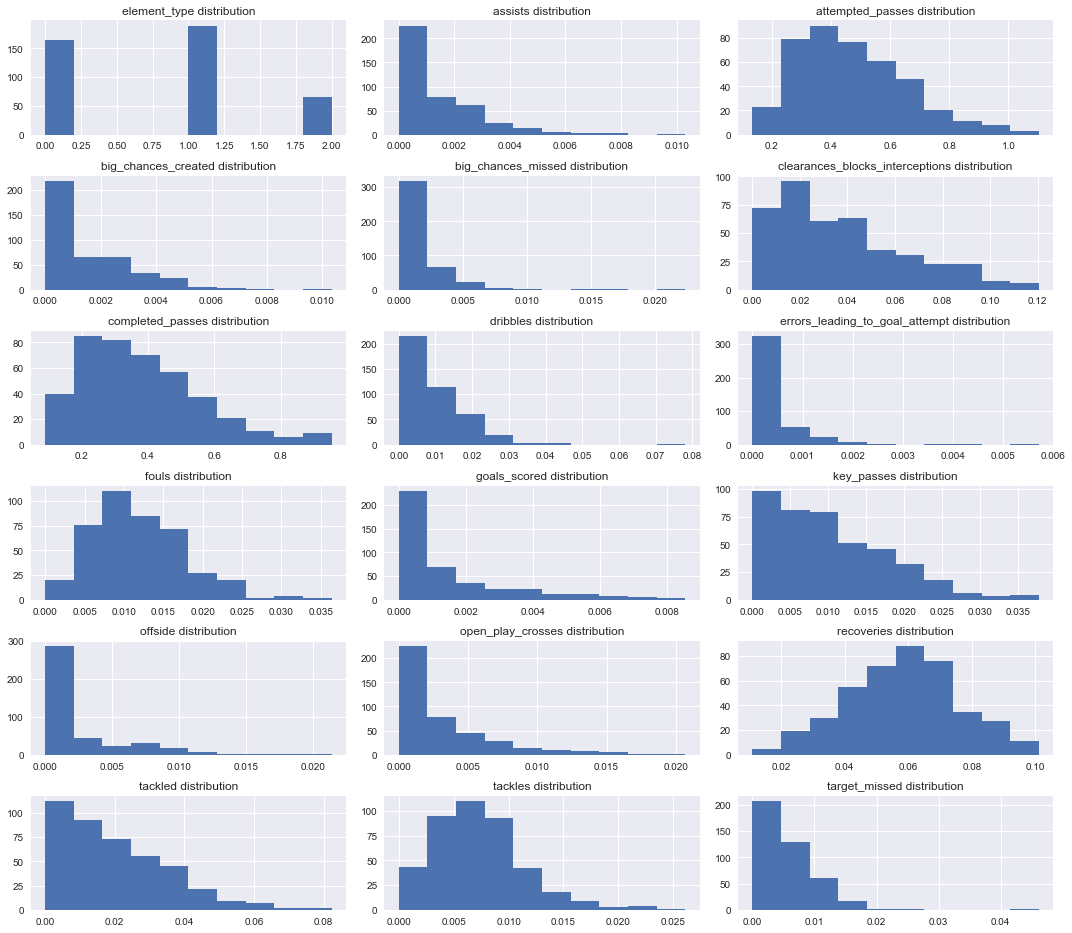

In [15]:
draw_histograms(data, data.columns, 7, 3)

In [16]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
element_type,418.0,0.763158,0.702091,0.000000,0.000000,1.000000,1.000000,2.000000
assists,418.0,0.001373,0.001630,0.000000,0.000000,0.000951,0.002191,0.010309
attempted_passes,418.0,0.473918,0.184378,0.134328,0.330838,0.446254,0.592326,1.102857
big_chances_created,418.0,0.001549,0.001720,0.000000,0.000000,0.000991,0.002521,0.010331
big_chances_missed,418.0,0.001404,0.002372,0.000000,0.000000,0.000514,0.002036,0.022388
clearances_blocks_interceptions,418.0,0.038421,0.027338,0.000000,0.015663,0.032758,0.053672,0.120465
completed_passes,418.0,0.383172,0.179218,0.089552,0.246869,0.354127,0.495640,0.954286
dribbles,418.0,0.009707,0.008895,0.000000,0.003263,0.007588,0.013912,0.078054
errors_leading_to_goal_attempt,418.0,0.000357,0.000733,0.000000,0.000000,0.000000,0.000479,0.005714
fouls,418.0,0.011999,0.006018,0.000000,0.007530,0.011106,0.015963,0.036364


After reviewing the overall distributions, let's take a deep dive and examine the distributions per player positions. At first look, it is evident that there are many outliers - regardless, removing them is not an option as we need them in the context of our problem. We expect that the combination of outliers across features will result in players who have a playing style and statistics similar to a different player group.

One thing we notice is that the distributions between defenders and midfielders is very similar across certain features such as passes, crosses, recoveries and tackles. They differ significantly however in clearances, blocks and interceptions, key passes and number of times the player was tackled.

When we compare the midfielders to the attackers there are also many similarities. However, the attackers' mean values are understandably higher for goals scored, big chances missed and offsides; and lower for passes, crosses and reoveries.

In [17]:
# plot boxplots of all player stats per minute
def draw_boxplots(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(15, 15))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df.boxplot([var_name], by='element_type',ax=ax)
        ax.set_title(var_name)
    fig.tight_layout()  
    
    plt.show()

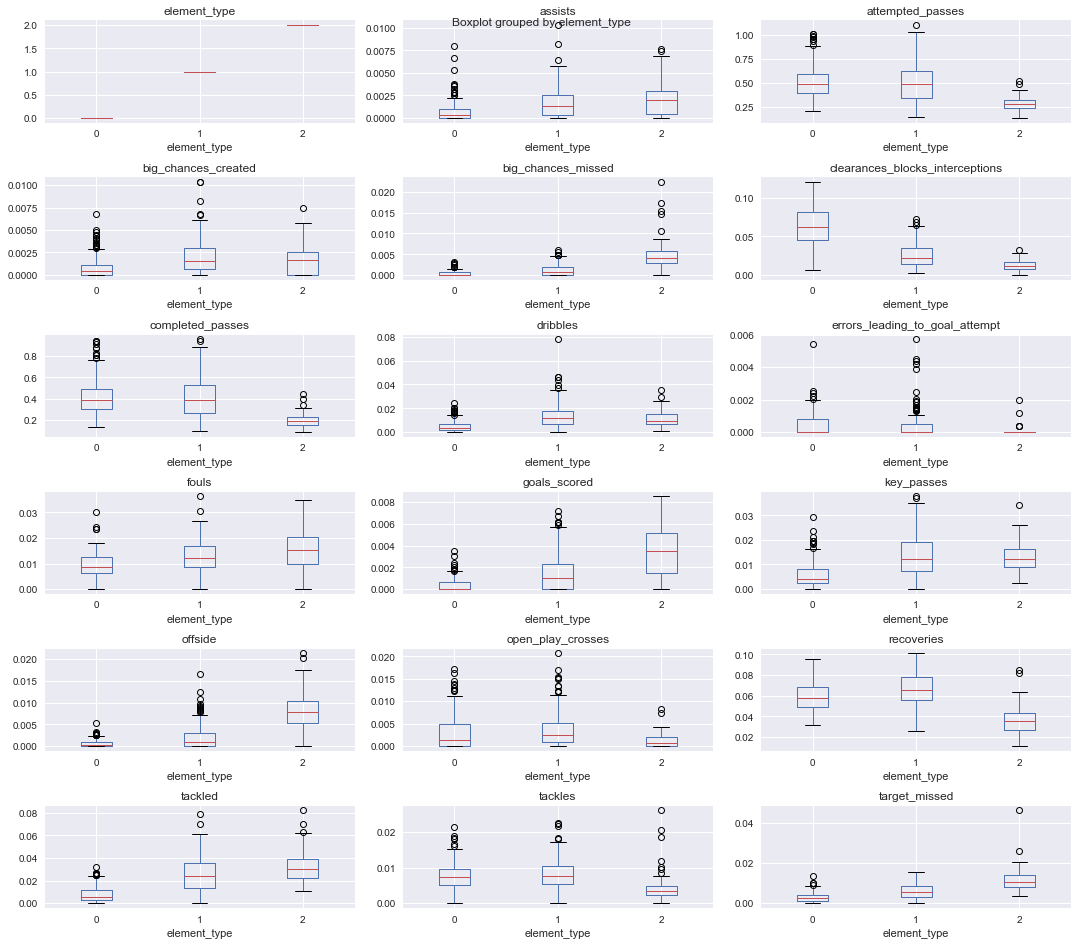

In [18]:
draw_boxplots(data, data.columns, 7, 3)

By reviewing the correlation matrix of the statistics we have selected as features we can see some intuitive correlations such as attempted passes < > completed passes (.99) and dribbles < > tackled (.75). The only feature we see that has a consistent negative correlation to the rest is clearances, blocks and interceptions but we are not going to leave it out as this is a defining characteristic of a defensive player and correlations will be addressed with PCA dimensionality reduction.

In [19]:
# get correlations between features in dataset 
def correlations (df):
    corrmat = df.corr()
    top_corr_features = corrmat.index
    plt.figure(figsize=(20,20))
    sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

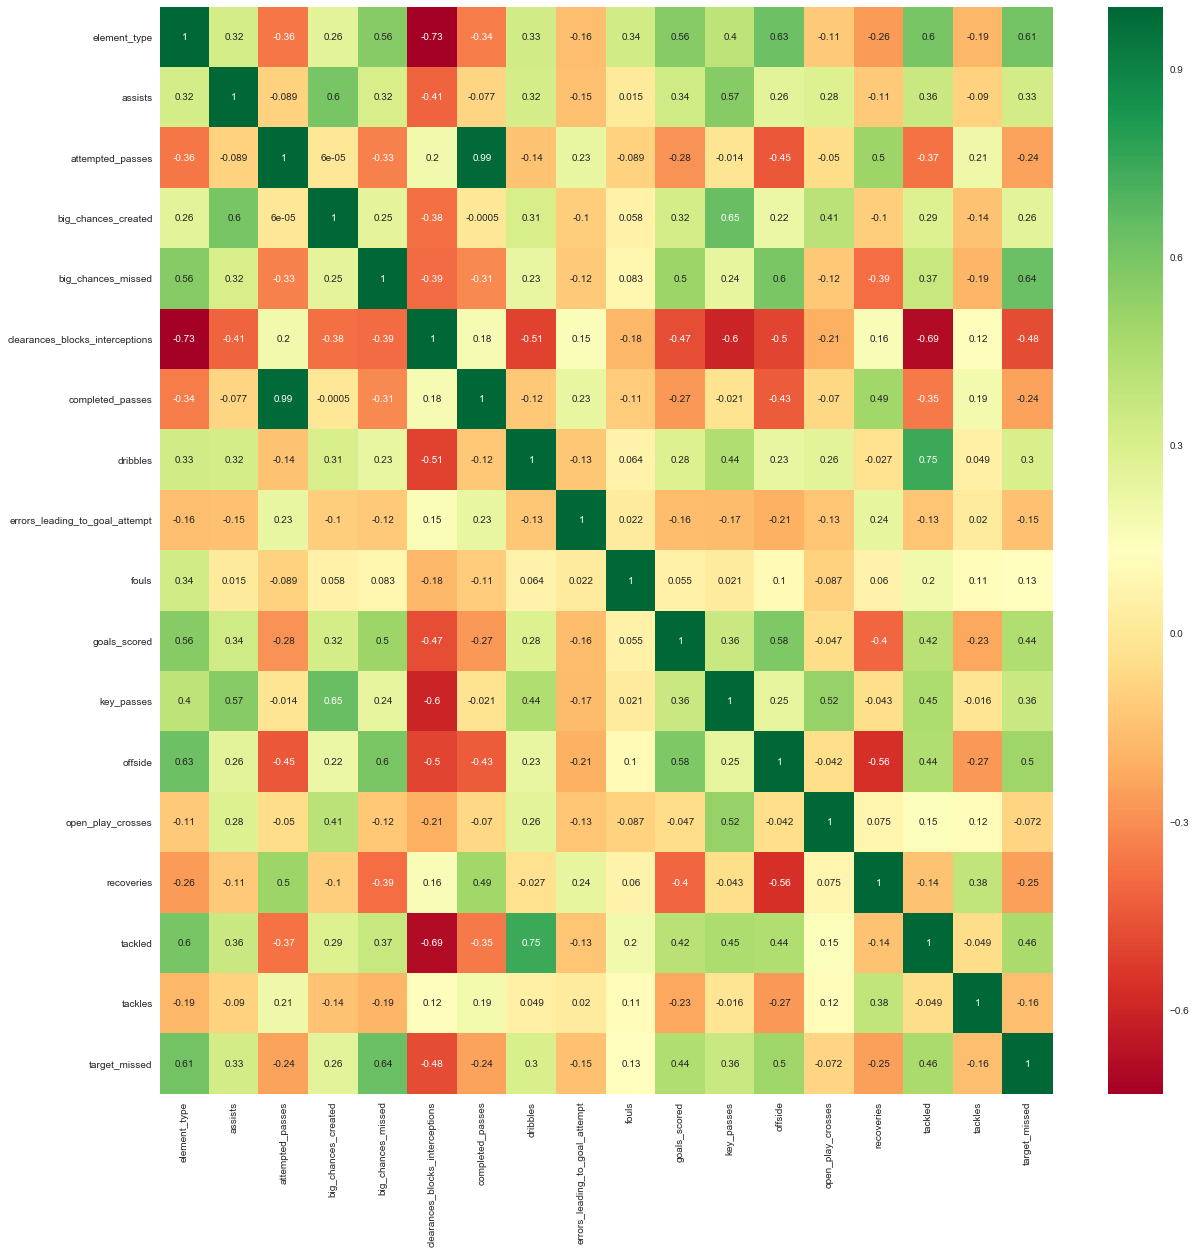

In [20]:
correlations(data)

# Clustering for feature extraction 

In this section, we are going to perform cluster analysis in order to identify groups of players, based on their statistics and characteristics, instead on their designated field positions. Our going-in position, is that we would like to ideally group them in three clusters - defender, midfielder and attacker; this can also be interpreted as a defensive player, an all-round player and an attacker. Of course, we are dropping the player position from the data to be clustered.

In [21]:
# scale the data and drop the original player position
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.drop(["element_type"], axis = 1))

As we have selected 17 features for our rather small dataset, it would be interesting to see if we can reduce the dimensionality and still keep a good level of variance. After performing Principal Component Analysis (PCA) on the scaled data, we can see that 9 components result in roughly 90% explained variance and 12 components in roughly 95%. Let's keep the latter, and move forward to clustering the data.

In [22]:
# PCA transformation
pca = PCA()
data_transformed = pca.fit_transform(data_scaled)
pca.explained_variance_ratio_

array([0.32067649, 0.15517661, 0.08746274, 0.08305061, 0.05464629,
       0.05388985, 0.0441244 , 0.03689533, 0.03338279, 0.0278198 ,
       0.02465771, 0.0206417 , 0.01866058, 0.01666654, 0.01280745,
       0.009091  , 0.00035013])

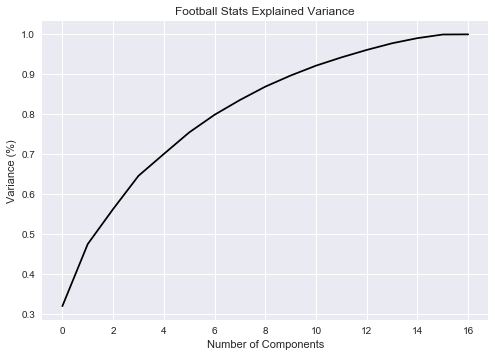

In [23]:
# plotting summation of explained variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_), color ="black")
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Football Stats Explained Variance')
plt.show()

In [24]:
data_reduced = data_transformed[:,:12]
data_reduced.shape

(418, 12)

We are first going to cluster our data using the K-Means algorithm and select as 'k' our desired number of clusters which is three. We get a set of predictions but before deciding whether we are going to use them, it is a good idea to evaluate the quality of the clusters. To do this, we are going to take advantage of the "elbow method" which produces a visual representation of the best number of clusters for a set of data points.

Unfortunately, we see in the plot that there is no single 'k' which is a good candidate for a cutoff point. The slope is descreasing gradually and smoothly. This could mean one of a few things. Either, we have made an error in the processing of our data or K-Means is not a good algorithm for our case (Mousse, 2014). We assume the latter due to the fact that the K-Means algorithm works under a number of assumptions which we can't verify for our dataset. Ideally, K-Means works with spherical clusters and some literature suggests that in order for the algorithm to work efficiently, a dataset of at least 500 records is required while Formann (1984) suggests the minimal sample size to include is no less than 2^k cases (k = n variables) (Dolnicar, 2002); after pre-processing, we have a dataset of 418 records.

In [25]:
# fitting kmeans model with 3 clusters
k_means = KMeans(n_clusters = 3, max_iter = 300, init = 'random')
k_means.fit(data_reduced)
k_clusters = k_means.predict(data_reduced)

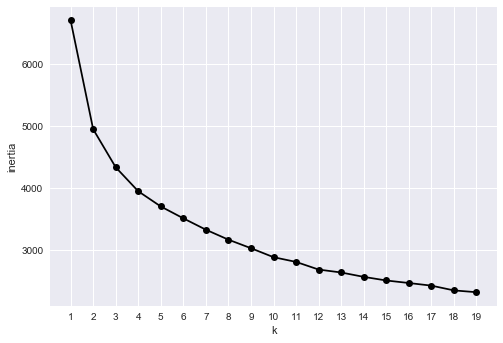

In [26]:
# elbow method for kmeans++
ks = range(1, 20)
inertias = []
for k in ks:
    # create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k, init = "k-means++")
    
    # fit model to samples
    model.fit(data_reduced)
    
    # append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

After discarding K-Means as a suitable algorithm for our problem, we are going to cluster the players with hierarchical clustering. This approach groups the data points based on their similarities; it performs better than K-Means on smaller datasets and handles better non-spherical cluster shapes, as it can be seen in the documentation ("Comparing different clustering algorithms on toy datasets"). 

By plotting the hierarchical agglomerative clustering algorithm on a dendogram, we can clearly distinguish two, three and four clusters of data. As per out initial intuition we are going to cut the dendogram as to obtain three clusters of data, also because this number produces a better silhouette score than four, five or six clusters. Two clusters produce a slightly better silhouette score but we chose to keep three  due to the context of the problem. The silhouette score of 22% can be interpreted as a low score meaning that we do not have dense or well separated clusters. Regardless, our subject matter in the domain suggests that we do have a meaningful clustering of players.

In [27]:
# fitting hierarchical clustering model with 3 clusters
aggl = AgglomerativeClustering(n_clusters = 3, linkage = 'ward')
aggl.fit(data_reduced)

assignments = aggl.labels_

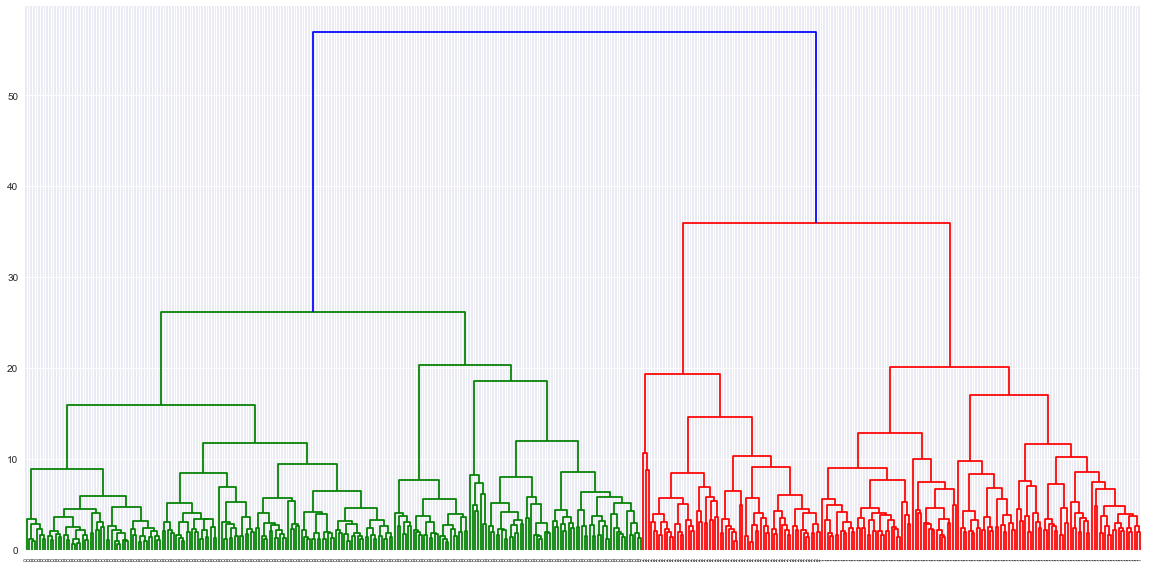

In [28]:
# plot dendogram
row_clusters = linkage(data_reduced, method = "ward", metric = "euclidean")
plt.figure(figsize = (20,10))
dendrogram(row_clusters, labels = assignments)
plt.show()

In [29]:
silhouette = silhouette_score(data_reduced, assignments, metric='euclidean')
silhouette

0.2247252994515041

We can see that originally in the dataset we started with 164 defenders, 189 midfielders and 65 attackers. Our three clusters (defensive, mid and attacking) have the following distribution: 231, 120 and 67, which suggests a large number of defensive midfielders.

In [30]:
# add assigned labels to dataframe
data["assignments"] = assignments

In [31]:
# check original player position distribution
data.groupby("element_type").size()

element_type
0    164
1    189
2     65
dtype: int64

In [32]:
# check assigned player position distribution

data.groupby("assignments").size()

assignments
0    231
1    120
2     67
dtype: int64

# External Validation of Clustering results

Once the labels are assigned, we need to evaluate quality. There are many methods to complete this step such as the "elbow method", the "silhouette analysis" and others, but there is always a level of subjectivity.

After studying the assigned labels, we noticed that the agglomerative clustering approach had produced three very interesting clusters. Those clusters contained, as initially anticipated, defensive players, 'all-round' players and attacking players. However, those clusters are quite different than the three designated field positions we had in the original dataset. Cluster 0 contains defenders and defensive midfielders; Cluster 1 contains attacking defenders and 'all-round' midfielders; and Cluster 2 contains attacking midfielders and attackers.

If we use this in a combination with the original player positions in the dataset, we come up with a new feature that we call 'difference' (between assigned labels and player position). A difference of -1 means that the player is similar to the more defensive cluster (e.g. midfield for an attacker, defense for a midfielder); a difference of 0 means that the player's position corresponds well to his statistics; and a difference of 1 means that the player is similar to the more offensive cluster (e.g. midfield for a defender, offense for a midfielder).

As our expertise and domain knowledge on football positions may not be enough to convince of our approach, we are conducting an external validation as follows:

The data we are working with is from the last Premier League season (2018/2019). At the start of the new 2019/2020 season the Fantasy Premier League announced that 10 players were reclassified - 6 moved to a more 'defensive' position (e.g forward to midfielder, midfielder to defender); and 4 moved to a more 'offensive' position (e.g defender to midfielder, midfielder to attacker). If we compare those players with our clusters, we can see that for the defensive switch our clustering model has indicated correctly 5 out of the 6 players (83%, 'difference = -1'); for the offensive switch our clustering model has indicated correctly 2 out of the 4 players (50%, 'difference = 1').

While this is far away from concrete proof that this is the best clustering approach for the data, it gives us recognition and confidence to move forward.


In [33]:
# list IDs for players who changed positions for the 2019/2020 season
changed_positions = [394, 432, 20, 410, 326, 406, 317, 141, 151, 279]
changed_attacking = [394, 432, 406, 141]
changed_defensive = [20, 410, 326, 317, 151, 279]

In [34]:
# calculate difference between player position label and assigned label
data["difference"] = data["assignments"]-data["element_type"]

In [35]:
changed_assigned = []
for index in changed_attacking:
    changed_assigned.append(data.difference[index])

In [36]:
changed_assigned

[1, 0, 0, 1]

In [37]:
changed_assigned2 = []
for index in changed_defensive:
    changed_assigned2.append(data.difference[index])

In [38]:
changed_assigned2

[-1, -1, -1, 0, -1, -1]

In [39]:
# function to check a particular player's labels and position
def check_id (id):
    return data.loc[id]

# Classification

Having clustered the players into three groups, we are going to use the new "difference" features extracted from the assigned labels as a target for classification. This will allow us to use the info from the 2019/19 season and classify players in the current season in terms of playing style. It is challenging that we are dealing with a small dataset but on top of this we have a dataset with strongly imbalanced classes. 

In the context of the problem, we are going to evaluate the algorithms based on their performance on the most interesting of the three classes (and the one with the least support); which is the clsuter of players who play in more attacking positions (labels = 1).

In [40]:
# separating labels
labels = data.difference

In [41]:
# separating attributes
attributes = data.drop(['assignments', "difference"], axis = 1)
attributes.element_type = attributes.element_type.astype(str)

In [42]:
# dealing with categorical variable - player position
attributes = pd.get_dummies(attributes)
attributes = attributes.drop('element_type_2', axis = 1)

In [43]:
# scaling the attributes
attributes = scaler.fit_transform(attributes)

In [44]:
# PCA transformation
pca = PCA()
data_transformed_class = pca.fit_transform(attributes)
pca.explained_variance_ratio_

array([3.13625096e-01, 1.62503943e-01, 9.00153606e-02, 7.85968634e-02,
       5.04435103e-02, 4.87741262e-02, 4.52288007e-02, 3.56442197e-02,
       3.29509536e-02, 2.99611873e-02, 2.22396654e-02, 2.05183260e-02,
       1.84687054e-02, 1.49497442e-02, 1.29968544e-02, 1.13870573e-02,
       7.82623474e-03, 3.56182366e-03, 3.07527984e-04])

In [45]:
#save reduction to new variable
attributes_reduced = data_transformed_class[:,:12]
attributes_reduced.shape

(418, 12)

In [46]:
# split train and test data
attributes_train, attributes_test, labels_train, labels_test = train_test_split(
    attributes_reduced, labels, stratify = labels, train_size =0.70)

In [47]:
# cross validation on training data
k_fold = StratifiedKFold(n_splits=5)
k_fold = k_fold.get_n_splits(attributes_train, labels_train)

Starting with a Decision Tree, we get a macro average training score 85%. As discussed earlier, in our f1 scoring, we are favoring the macro-averaged accuracy as it treats the imbalanced classes as equals. While micro-averaging would maximize the number of correct predictions of the classifier and therefore result in a higher scoring, this wouldn't give us a good prediction on the number of players who play more offensive than their on-field position supposes. The f1 score for Class 1 is 69% and with a very low recall of 53%. 

Usually, we can use a Random Forest algorithm to improve on the performance on the decision tree but once tested it overfits the data way too much. For this reason, we are trying to optimize a different algorithm alltogether. 

In [48]:
# parameters for gridsearch
params_tree = {
    "max_depth":[5,10,20,40],
    "min_samples_leaf":[1,2,5,10,20],
    "max_leaf_nodes":[10,20,40,80,120]
}

# gridsearch decision tree
grid_search = GridSearchCV(DecisionTreeClassifier(), 
                           params_tree, make_scorer(f1_score, average='macro'), cv = k_fold)

# fit
grid_search.fit(attributes_train, labels_train)

# best estimator
tree_classifier = grid_search.best_estimator_

grid_search.best_estimator_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\c

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\c

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\c

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\c

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\c

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\c

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=20,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [49]:
# feature importances
grid_search.best_estimator_.feature_importances_

array([0.33303767, 0.05218639, 0.49209597, 0.        , 0.        ,
       0.0165421 , 0.04657104, 0.0172929 , 0.        , 0.0353814 ,
       0.00689254, 0.        ])

In [50]:
# classification report
print(classification_report(labels_train, tree_classifier.predict(attributes_train)))

              precision    recall  f1-score   support

          -1       0.92      0.89      0.90        64
           0       0.93      0.98      0.96       209
           1       1.00      0.53      0.69        19

    accuracy                           0.93       292
   macro avg       0.95      0.80      0.85       292
weighted avg       0.93      0.93      0.93       292



The next algorithm which we will train to try and improve our score is Linear SVM. Our data size will again present problems and we can see that the linear SVM fails to converge. A macro averaged training score of 67% on the training data is way lower than the Decision Tree and we see that correct predictions for Class 1 are few. This may be due to the PCA transformation which makes our features linearly independent.

In [51]:
# parameters for gridsearch
params_SVM = {
    "C": [0.1,1,10,100,1000,10000,100000]
}

# gridsearch linear SVM
grid_search = GridSearchCV(LinearSVC(class_weight = 'balanced'), params_SVM, 
                           make_scorer(f1_score, average='macro'),cv = k_fold)

# fit
grid_search.fit(attributes_train, labels_train)

# best estimator
linear_svm_classifier = grid_search.best_estimator_

grid_search.best_estimator_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

LinearSVC(C=0.1, class_weight='balanced', dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [52]:
# classification report
print(classification_report(labels_train, linear_svm_classifier.predict(attributes_train)))

              precision    recall  f1-score   support

          -1       0.78      0.94      0.85        64
           0       0.91      0.89      0.90       209
           1       0.36      0.21      0.27        19

    accuracy                           0.86       292
   macro avg       0.68      0.68      0.67       292
weighted avg       0.85      0.86      0.85       292



Cover's theorem states that by increasing the dimensionality you are more likely to be able to describe the data points linearly with a hyperplane. We can do this with a kernel trick Support Vector Machine algorithm to see if we can improve on the performance. Our intuition is that the linear SVM results can be interpreted as in that there is no good linear separation of our data. This is in line with our k-means algorithm where we observed that there is not an optimal number of k for clustering.

After optimizing the algorithm, we can see that with the kernel trick we receive very decent results of 93% macro average f1 score and 86% for Class 1.

In [53]:
# parameters for gridsearch
params_SVM_kernel = {
    "C": [1, 10, 100, 1000],
    "gamma": [0.001, 0.01, 0.1, 1, 10]
}

# gridsearch kernel SVM
grid_search = GridSearchCV(SVC(class_weight = 'balanced'), params_SVM_kernel, 
                           make_scorer(f1_score, average ='macro'),cv = k_fold)

# fit
grid_search.fit(attributes_train, labels_train)

# best estimator
gaussian_svm_classifier = grid_search.best_estimator_
grid_search.best_estimator_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\c

SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [54]:
# classification report
print(classification_report(labels_train, gaussian_svm_classifier.predict(attributes_train)))

              precision    recall  f1-score   support

          -1       0.95      0.97      0.96        64
           0       1.00      0.96      0.98       209
           1       0.76      1.00      0.86        19

    accuracy                           0.97       292
   macro avg       0.90      0.98      0.93       292
weighted avg       0.97      0.97      0.97       292



Let's review how the kernel SVM performs on the testing data. We see that we have good bias with although the macro average f1 score has decreased to 85% This suggests that we have slight overfit on the training data. However, if we isolate the results only to Class 1, get scores of 86% and 84% which shows significantly less variance on our most interesting class

Compared to our Decision Tree and Linear SVM, the kernel SVM performs significantly better, as seen by the results below.

In [55]:
# macro average f1 on train and test kernel SVM
gaussian_svm_classifier_score_train = f1_score(labels_train, gaussian_svm_classifier.predict(attributes_train), average = 'macro')
gaussian_svm_classifier_score = f1_score(labels_test, gaussian_svm_classifier.predict(attributes_test), average = 'macro')

print("Testing scores kernel SVM:")
print("Gaussian SVM train:", gaussian_svm_classifier_score_train)
print("Gaussian SVM test:", gaussian_svm_classifier_score)

Testing scores kernel SVM:
Gaussian SVM train: 0.934326287831635
Gaussian SVM test: 0.8534949742380084


In [56]:
# classification report test kernel SVM
print(classification_report(labels_test, gaussian_svm_classifier.predict(attributes_test)))

              precision    recall  f1-score   support

          -1       0.87      0.71      0.78        28
           0       0.92      0.94      0.93        90
           1       0.73      1.00      0.84         8

    accuracy                           0.90       126
   macro avg       0.84      0.89      0.85       126
weighted avg       0.90      0.90      0.89       126



In [57]:
# macro average f1 on train and test decision tree
tree_classifier_score_train = f1_score(labels_train, tree_classifier.predict(attributes_train), average = 'macro')
tree_classifier_score = f1_score(labels_test, tree_classifier.predict(attributes_test), average = 'macro')

print("Testing scores Decision Tree:")
print("Decision Tree train:", tree_classifier_score_train)
print("Decision Tree test:", tree_classifier_score)

Testing scores Decision Tree:
Decision Tree train: 0.8500426776288844
Decision Tree test: 0.7092145713427178


In [58]:
# macro average f1 on train and test linear SVM
linear_svm_classifier_score_train = f1_score(labels_train, linear_svm_classifier.predict(attributes_train), average = 'macro')
linear_svm_classifier_score = f1_score(labels_test, linear_svm_classifier.predict(attributes_test), average = 'macro')

print("Testing scores Linear SVM:")
print("Linear SVM train:", linear_svm_classifier_score_train)
print("Linear SVM test:", linear_svm_classifier_score)

Testing scores Linear SVM:
Linear SVM train: 0.6728189629019056
Linear SVM test: 0.5658457408621281


# Conclusions and Limitations
## Conclusions

After analyzing the mean points per 90 minutes, obtained by the players in the cluster categories, as expected, the best performers are the midfielders which have statistics similar to those of attackers.  It is surprising however, that very close after are the attackers who have statistics similar to modfielders. From then on, those are followed by the attackers, midfielders, attacking defenders, defensive midfielders and defenders. This is the first time we introduce the actual Fantasy Premier League points of the players in this analysis, and we do so, to validate our initial hypothesis - players who play more offensive than what their position on the field supposes, would be a better Fantasy Premier League investment. This is true with the exception of the attackers who actually have statistics similar to those of midfielders. This is further validation on the quality of our clusters and could be used to inform Fantasy Premier League decisions.

Although, the size of our dataset presented constraints, we trained classification models with our cluster results as target. Our best model is a SVM classifier with kernel trick which achieves 93% average training score and 85% testing score, while maintaining high and consistent results across our most interesting class. This classifier can be used to identify "real positions" and playing style of football players from the Premier League, given their underlyiing statistics per minute played.

In [59]:
# get a df with player names, position, classification target, 
# total points, total minutes and points per minute(ppm)
data_concl = data.merge(data_totals, how = 'outer', left_on='element', right_on = 'id')
data_concl.columns
data_concl = data_concl[["first_name", "second_name","element_type_x", "difference", "total_points", "minutes_season"]]
data_concl = data_concl.dropna()
data_concl2 = data_concl["total_points"].div(data_concl.minutes_season, axis = 0)
data_concl["ppm"] = data_concl2
data_concl.head()

,first_name,second_name,element_type_x,difference,total_points,minutes_season,ppm
0,Laurent,Koscielny,0.0,0.0,62,1329,0.046652
1,HÃ©ctor,BellerÃ­n,0.0,0.0,60,1532,0.039164
2,Nacho,Monreal,0.0,0.0,77,1860,0.041398
3,Rob,Holding,0.0,0.0,24,806,0.029777
4,Shkodran,Mustafi,0.0,0.0,80,2611,0.030640


In [60]:
# function to return mean ppm for combinations of player position and classification target
def ppm (position, diff):
    mean = data_concl.loc[(data_concl['element_type_x'] == position) & 
                                     (data_concl['difference'] == diff)].ppm.mean()
    return(mean)

In [61]:
print("Mean points per 90' for defenders:", ppm (0, 0)*90)
print("Mean points per 90' for attacking defenders:", ppm (0, 1)*90)
print("Mean points per 90' for mids:", ppm (1, 0)*90)
print("Mean points per 90' for attacking mids:", ppm (1, 1)*90)
print("Mean points per 90' for defensive mids:", ppm (1, -1)*90)
print("Mean points per 90' for attackers:", ppm (2, 0)*90)
print("Mean points per 90' for mid attackers:", ppm (2, -1)*90)

Mean points per 90' for defenders: 2.9479153374702047
Mean points per 90' for attacking defenders: 4.110190077630165
Mean points per 90' for mids: 4.581626577454034
Mean points per 90' for attacking mids: 5.787937660579206
Mean points per 90' for defensive mids: 3.0902486650104755
Mean points per 90' for attackers: 5.018693071806199
Mean points per 90' for mid attackers: 5.6876903496000395


## Limitations

In this section, we are going to discuss the limitations we encountered during the preparation of this analysis, suggestions for alternative approaches and lessons learned.

First and foremost, throughout the analysis we have encountered the constraint of the size of our dataset. Although, producing very interesting results, our clustering algorithms scored low on metrics such as silhouette score and elbow method. This could be a result of our sample size. Later, during the classification phase, we observed that the Linear SVM model failed to converge - again due to the size of the training data.

The impact of the small size of our dataset was augmented by the fact that it contains imbalanced data. The player positions as a class are not balanced, and our clustering further increased this imbalance.

Increasing the dataset was investigated as an opportunity throughout the project. For example, there is available data from previous seasons that can be included but this would have added the complexity of time; and would discard the evoluation and natural progression of a player throughout the years of his career. 

Another approach, that we didn't have time to investigate but would certainly recommend is the use of anomaly detection algorithms such as Isolation Forest. This could be done by player position to identify the players who deviate from the standard performance of their position.

Finally, of course there is the limit of the content of our data itself. We are looking at a sample with players from different teams - teams that have different philosphies, playing styles, and positional tactics. As an example, the central defender of a team like Manchester City that has an average posession of the ball of 70%+ per game, may have a higher passing rate than the playmaker of the opposition team. While, the dataset contains a wide range of football statistics, our models don't take into account a number of other important factors such as fixture difficulties, team performance, form etc.


# References

Dolnicar, S. (2002). A Review of Unquestioned Standards in Using Cluster Analysis for Data-Driven Market Segmentation.
Deakin University, Melbourne. Retrieved from http://ro.uow.edu.au/cgi/viewcontent.cgi?article=1286&context=commpapers

Fantasy Premier League. (2019, June 27). FPL position changes for 2019/20. Retrieved from https://www.premierleague.com/news/1257639.

Hale, J. (2019, July 16). Scale, Standardize, or Normalize with Scikit-Learn. Retrieved from https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02.

Mousse, A. (2014, April 14). What do you do when there's no elbow point for kmeans clustering. Retrieved from https://stats.stackexchange.com/questions/89679/what-do-you-do-when-theres-no-elbow-point-for-kmeans-clustering.

scikit-learn. (n.d.). Comparing different clustering algorithms on toy datasets¶. Retrieved from https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html.

Wade, C. (2018, August 21). Transforming Skewed Data. Retrieved from https://towardsdatascience.com/transforming-skewed-data-73da4c2d0d16.